In [8]:
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [15]:
# 학습 데이터와 테스트 데이터를 비율을 지정해서 무작위로 분리하기 위해 train_test_split() 함수를 import 한다.
from sklearn.model_selection import train_test_split
# 교차 검증을 실행하기 위해서 cross_val_score() 함수를 import 한다.
from sklearn.model_selection import cross_val_score
# kNN 분류기를 사용하기 위한 KNeighborsClassifier() 함수를 import 한다.
from sklearn.neighbors import KNeighborsClassifier
# 모델의 정확도를 계산하는 accuracy_score() 함수를 import 한다.
from sklearn.metrics import accuracy_score

데이터 획득

In [16]:
df = pd.read_csv('./data/basketball_stat.csv')
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Player,Pos,3P,2P,TRB,AST,STL,BLK
0,Alex Abrines,SG,1.4,0.6,1.3,0.6,0.5,0.1
1,Steven Adams,C,0.0,4.7,7.7,1.1,1.1,1.0
2,Alexis Ajinca,C,0.0,2.3,4.5,0.3,0.5,0.6
3,Chris Andersen,C,0.0,0.8,2.6,0.4,0.4,0.6
4,Will Barton,SG,1.5,3.5,4.3,3.4,0.8,0.5


In [17]:
df.Pos.value_counts()

Pos
SG    50
C     50
Name: count, dtype: int64

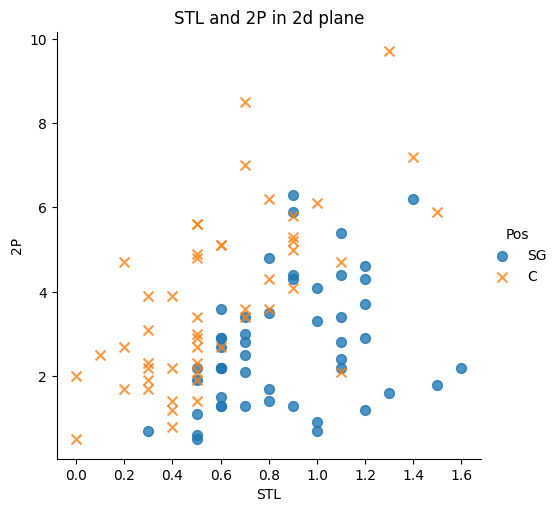

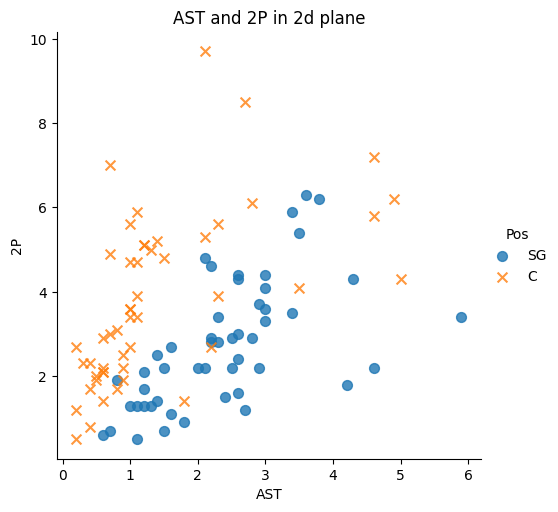

In [18]:
# STL(스틸)과 2P(2점슛), AST(어스시트)와 2P(2점슛)의 Pos(포지션) 별 분포도를 출력한다.
sns.lmplot(
    data=df, x='STL', y='2P', fit_reg=False, # 데이터, x축, y축, 회귀선 표시 여부
    hue='Pos', # 그래프에 표시될 표식의 색상
    markers=['o', 'x'], # 그래프에 표시될 표식의 종류
    scatter_kws={'s': 50} # 그래프에 표시될 표식의 크기
)
plt.title('STL and 2P in 2d plane')
sns.lmplot(data=df, x='AST', y='2P', fit_reg=False, hue='Pos', markers=['o', 'x'], scatter_kws={'s': 50})
plt.title('AST and 2P in 2d plane')
plt.show()

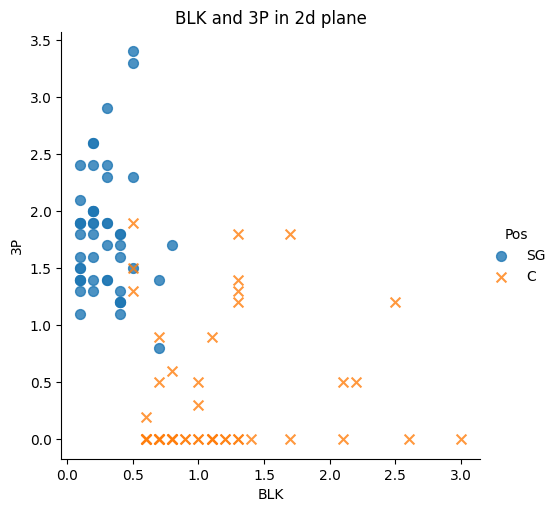

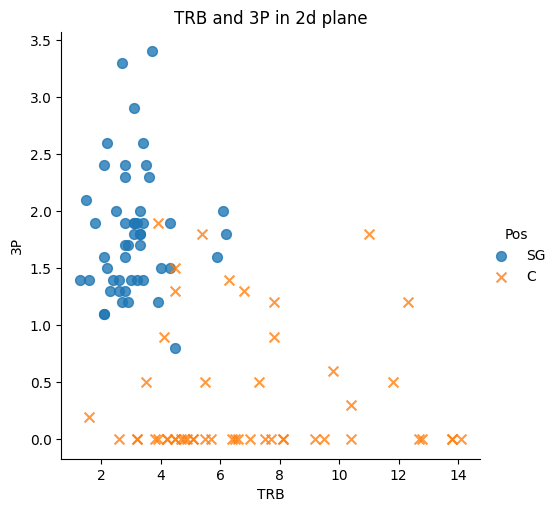

In [19]:
# BLK(블로킹)과 3P(3점슛), TRB(리바운드)와 3P(3점슛)의 Pos(포지션) 별 분포도를 출력한다.
sns.lmplot(data=df, x='BLK', y='3P', fit_reg=False, hue='Pos', markers=['o', 'x'], scatter_kws={'s': 50})
plt.title('BLK and 3P in 2d plane')
sns.lmplot(data=df, x='TRB', y='3P', fit_reg=False, hue='Pos', markers=['o', 'x'], scatter_kws={'s': 50})
plt.title('TRB and 3P in 2d plane')
plt.show()

In [20]:
# 판다스의 drop() 함수로 불필요한 컬럼(피쳐)를 삭제한다.
# axis 속성은 생략시 0이 기본값이며 행 단위로 삭제를 하고 1을 쓰면 열 단위로 삭제를 한다.
# df = df.drop(['2P', 'AST', 'STL'], axis=1)
# inplace 속성은 생략시 False가 기본값이며 실행한 결과를 반영하지 않고 True를 쓰면 결과를 바로 반영한다.
df.drop(['2P', 'AST', 'STL'], axis=1, inplace=True)
df.head()

,Player,Pos,3P,TRB,BLK
0,Alex Abrines,SG,1.4,1.3,0.1
1,Steven Adams,C,0.0,7.7,1.0
2,Alexis Ajinca,C,0.0,4.5,0.6
3,Chris Andersen,C,0.0,2.6,0.6
4,Will Barton,SG,1.5,4.3,0.5


In [21]:
# train_test_split() 함수는 학습 데이터와 테스트 데이터의 비율을 지정하지 않으면 학습 데이터 75%, 테스트 데이터 25% 비율로
# 데이터를 나눈다.
# train_size 옵션으로 학습 데이터 비율을 지정할 수 있다. 나머지는 자동으로 테스트 데이터의 비율로 인식된다.
# test_size 옵션으로 테스트 데이터 비율을 지정할 수 있다. 나머지는 자동으로 학습 데이터의 비율로 인식된다.
# 데이터의 80%를 학습용 데이터로 데이터의 20%를 테스트 데이터로 무작위로 분리한다.
train, test = train_test_split(df, test_size=0.2)
print(train.shape[0], test.shape[0])

80 20


In [22]:
# 교차 검증을 실행하기 위해서 cross_val_score() 함수를 import 한다.
from sklearn.model_selection import cross_val_score

최적의 kNN 파라미터 찾기  
sklearn 라이브러리의 cross_val_score() 함수로 k-fold 교차 검증을 사용해서 kNN 알고리즘의 조절 가능한 단 하나의 변수 k를 찾는다.  
k-fold 교차 검증은 기존 데이터를 k개로 나눠서 k번 정확도를 검증하는 방법이다.  

<img src='./images/k-fold.png' align='left'>